In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import Model
import warnings

warnings.simplefilter('ignore', FutureWarning)

if __name__ == "__main__":
	t0 = time.time()
	featureList = ['EPS Growth', 'Volatility 180 D', 'Trailing EPS', 'Price to Cash Flow', 'EPS', 'Volume', 'Return on Assets', 'Price to Book', 'Dividend Yield', 'Total Debt to Total Equity', 'Return on Invested Capital', 'Return on Common Equity']
	train, validate, test = Model.splitData(300,3,12)
	randForest = Model.buildWithIndexesTripleClass(modelType = Model.randomForestClassifier, indexes = train, target= 'Rate of Return', features = featureList, featureLength = 12,\
									targetLength = 3, sector = "Energy", percentileTarget = 90, percentileAvoid = 10, verbose = True)
	print("Labels: ")
	print(randForest.classes_)
	print("Importances: ")
	print(randForest.feature_importances_)

[ -70  -34  -91 -259 -109 -298 -256 -193 -115 -226 -244 -151 -247 -241 -223
 -214  -94 -148 -199 -139  -22 -184  -97 -130  -49 -229 -220 -196  -19 -268
 -211 -136 -157  -64  -25 -286 -154  -43  -82 -283 -166  -73  -28 -202 -295
 -118  -31 -145  -67  -37 -217  -85 -277 -235  -58 -175 -181]
[-301 -250 -190 -265  -55 -262  -46 -253 -172 -187 -292 -100 -163 -271 -127
 -289 -142 -208 -160]
[-121  -79  -88 -238 -133 -124 -169 -178 -274  -16  -40  -61 -112 -103  -76
  -52 -280 -205 -106 -232]
Finished data retrieval, starting model training. Time taken: 86.77059292793274 seconds.
Finished fitting. Time taken: 11.765755891799927 seconds.
Labels: 
[0 1 2]
Importances: 
[ 0.08954709  0.11294397  0.08193732  0.0904829   0.0815213   0.10060939
  0.04487223  0.09270961  0.04517356  0.09091427  0.08585909  0.08342928]


In [2]:
precisions = {'seen':{}, 'above10':{}, 'above75':{}, 'above50':{}, 'above25':{}, 'above90':{}}
betterThan = {}
for prob in range(0,100,5):
	precisions['seen'][prob] = 0
	precisions['above10'][prob] = 0
	precisions['above75'][prob] = 0
	precisions['above50'][prob] = 0
	precisions['above25'][prob] = 0
	precisions['above90'][prob] = 0
for i in validate:
	addedStocks, probabilities = Model.predict_probabilities(randForest, startIndex = i, endIndex = i+11, features = featureList, sector = "Energy")
	actual = []
	for prob in range(0,100,5):
		betterThan[prob] = []
	for stock in addedStocks:
		actual.append(Model.rateOfReturn(Model.retrieveData(stock, 'Last Price', i+12, i+14, [])))
	for i in range(len(probabilities)):
		for prob in range(0,100,5):
			if probabilities[i][1] > prob / 100:
				betterThan[prob].append(1)
			else:
				betterThan[prob].append(0)
	for prob in range(0,100,5):
		if sum(betterThan[prob]) > 0:
			precisions['above10'][prob] = (Model.precision(Model.getPercentile(actual, 10),betterThan[prob]) * len(betterThan[prob]) + precisions['above10'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above75'][prob] = (Model.precision(Model.getPercentile(actual, 75),betterThan[prob]) * len(betterThan[prob]) + precisions['above75'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above50'][prob] = (Model.precision(Model.getPercentile(actual, 50), betterThan[prob]) * len(betterThan[prob]) + precisions['above50'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above25'][prob] = (Model.precision(Model.getPercentile(actual, 25), betterThan[prob]) * len(betterThan[prob]) + precisions['above25'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['above90'][prob] = (Model.precision(Model.getPercentile(actual, 90), betterThan[prob]) * len(betterThan[prob]) + precisions['above90'][prob] * precisions['seen'][prob]) / (precisions['seen'][prob] + len(betterThan[prob]))
			precisions['seen'][prob] = precisions['seen'][prob] + len(betterThan[prob])
x = []
y90 = []
y75 = []
y50 = []
y25 = []
y10 = []
counts = []
for prob in range(0,100,5):
	print(str(prob) + " above 90th percentile: " + str(precisions['above90'][prob]))
	print(str(prob) + " above 75th percentile: " + str(precisions['above75'][prob]))
	print(str(prob) + " above 50th percentile: " + str(precisions['above50'][prob]))
	print(str(prob) + " above 25th percentile: " + str(precisions['above25'][prob]))
	print(str(prob) + " above 10th percentile: " + str(precisions['above10'][prob]))
	counts.append(sum(betterThan[prob]))
	if (precisions['above10'][prob]) > 0:
		y90.append(precisions['above90'][prob])
		y75.append(precisions['above75'][prob])
		y50.append(precisions['above50'][prob])
		y25.append(precisions['above25'][prob])
		y10.append(precisions['above10'][prob])
		x.append(prob)

print(time.time() - t0, "seconds wait time")

0 above 90th percentile: 0.104447672673
0 above 75th percentile: 0.250480742613
0 above 50th percentile: 0.493398660307
0 above 25th percentile: 0.741527368293
0 above 10th percentile: 0.889647936102
5 above 90th percentile: 0.141129484936
5 above 75th percentile: 0.286234133871
5 above 50th percentile: 0.503547462515
5 above 25th percentile: 0.736452166008
5 above 10th percentile: 0.887935099531
10 above 90th percentile: 0.172990162204
10 above 75th percentile: 0.317981565332
10 above 50th percentile: 0.51742447842
10 above 25th percentile: 0.727446451894
10 above 10th percentile: 0.891492237235
15 above 90th percentile: 0.202404143771
15 above 75th percentile: 0.362198827884
15 above 50th percentile: 0.532284632567
15 above 25th percentile: 0.727694295261
15 above 10th percentile: 0.892307375362
20 above 90th percentile: 0.215213856022
20 above 75th percentile: 0.365794801683
20 above 50th percentile: 0.540674871489
20 above 25th percentile: 0.729010467163
20 above 10th percentile: 0

Counts: 
[85, 52, 39, 28, 23, 20, 16, 14, 9, 5, 4, 3, 2, 2, 2, 1, 1, 0, 0, 0]


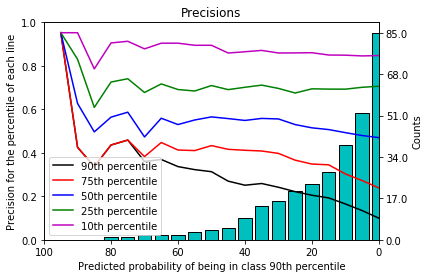

In [3]:
print("Counts: ")
print(counts)
fig = plt.figure()
axes = plt.gca()
axes.set_xlim([0,100])
axes.set_xlim([0,100])
plt.title("Precisions")
plt.xlabel('Predicted probability of being in class 90th percentile')
plt.ylabel('Precision for the percentile of each line')
axes.invert_xaxis()
bar = axes.twinx()
rects = bar.bar(x = list(range(0,100,5)), height = list(map(lambda x: x/max(counts),counts)), width = 4, color = 'c', linestyle = 'solid', edgecolor = 'k', zorder = -1)
bar.set_yticklabels(list(map(lambda x: x * max(counts) / 5, range(0,6,1))))
bar.set_ylabel('Counts', color = 'k')
plt.plot(x, y90, color = 'k', label = "90th percentile")
plt.plot(x, y75, color = 'r', label = "75th percentile")
plt.plot(x, y50, color = 'b', label = "50th percentile")
plt.plot(x, y25, color = 'g', label = "25th percentile")
plt.plot(x, y10, color = 'm', label = "10th percentile")
plt.legend()

In [4]:
fig.savefig(str(time.time()) + 'test.jpg', dpi=900)
plt.show()

Feature ranking:
1. Volatility 180 D (0.112944)
2. Volume (0.100609)
3. Price to Book (0.092710)
4. Total Debt to Total Equity (0.090914)
5. Price to Cash Flow (0.090483)
6. EPS Growth (0.089547)
7. Return on Invested Capital (0.085859)
8. Return on Common Equity (0.083429)
9. Trailing EPS (0.081937)
10. EPS (0.081521)
11. Dividend Yield (0.045174)
12. Return on Assets (0.044872)


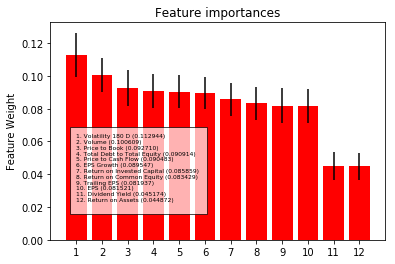

In [5]:
# adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

importances = randForest.feature_importances_
std = np.std([est.feature_importances_ for est in randForest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
textString = ''
for f in range(len(featureList)):
    print("%d. %s (%f)" % (f + 1, featureList[indices[f]], importances[indices[f]]))
    textString += "%d. %s (%f) \n" % (f + 1, featureList[indices[f]], importances[indices[f]])

# Plot the feature importances of the forest
fig2 = plt.figure()
plt.title("Feature importances")
plt.bar(range(len(featureList)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(featureList)), range(1,len(featureList)+1))
plt.xlim([-1, len(featureList)])
plt.ylabel('Feature Weight')
plt.text(0, 0.02, textString,
        bbox={'facecolor':'white', 'alpha':0.7, 'pad':6}, fontsize=6)
fig2.savefig(str(time.time()) + 'feature_importances.jpg', dpi=900)
plt.show()

In [6]:
dtree = randForest.estimators_[0]
Model.visualizeDecisionTreeClassifier(dtree, "tree2", featureList)